# TextRank
Mihalcea, R., & Tarau, P. (2004). TextRank: Bringing Order into Texts. In TextRank: Bringing Order into Texts (pp. 404–411).

TextRank is a graph-based method for unsupervised keyword and sentence extration for summarizing text.

## Algorithm

1. Identify units of text
    - E.g. words or sentences
    - TextRank selects one or more of those units as the summary
2. Define similarity between units
    - E.g. co-occurance or cosine similarity
    - The similairities determine the weights in the PageRank GoogleMatrix
3. Apply weighted PageRank
    - $WS(V_i) = (1-d) + d * \sum_{V_j \in \text{In}(V_i)} \frac{w_{ji}}{\sum_{v_k \in \text{Out}(V_j)} w_{ji}} WS(V_j)$
    - Proportional to randomly following links and counting visits
    - Considers number of in-bound links from important units
4. Select the top ranked units as the summary

## Advantages & disadvantages

- Easy to understand and implement
- and fast and scalable

But,

- only extractive summarization on pre-defined units
- state-of-the-art performance is much better

In [1]:
import re

import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

from wikipedia import query_wikipedia
from sentence_preprocessing import split_sentences, filter_sentences, clean_sentence
from pretty_print import print_with_emphasis, print_summary
from textrank import summarize_wiki

In [2]:
with open('stopwords.json', 'r') as fin:
    STOP_WORDS = json.load(fin)

In [3]:
def sentence_similarity(sentences, stop_word_language=None):
    """Compute similarity between sentences
    
    Using:
    - cosine similarity on
    - character n-grams
    """
    stop_words = STOP_WORDS.get(stop_word_language, None)
    vectorizer = TfidfVectorizer(analyzer='char_wb', min_df=0.05, max_df=0.5, ngram_range=(3, 10), stop_words=stop_words)
    vectors = vectorizer.fit_transform(sentences)
    similarity = metrics.pairwise.cosine_similarity(vectors, vectors)
    return similarity

In [4]:
def edge_weights(similarity, d=0.85):
    """Transform sentence similarities to proper normalized weights
    
    :param d: damping factor, percentage of jumps to random vertex
    """
    weights = similarity
    np.fill_diagonal(weights, 0)
    weights = normalize(weights, 'l1', axis=0)
    weights = (1 - d) / weights.shape[0] + d * weights
    return weights

In [5]:
def compute_rank_naive(weights, steps=100):
    """Compute rank by iterative updating
    
    Similar to first eigenvector if the number of steps is large enough
    """
    rank = np.ones(weights.shape[0])
    for _ in range(steps):
        rank = np.array([weights[:,i].dot(vertices) for i in range(rank.shape[0])])
    return rank

In [6]:
def compute_rank_eigenvector(weights):
    """Compute rank by eigenvector decomposition"""
    eigenvalue, eigenvector = np.linalg.eig(weights)
    ind = eigenvalue.argmax()
    largest_vector = np.abs(eigenvector[:, ind])
    return (largest_vector - largest_vector.min()) / (largest_vector.max() - largest_vector.min())

In [7]:
text = query_wikipedia('police', 'en')
text.split('\n')[0]

'The police are a constituted body of persons empowered by a state to enforce the law, to protect the lives, liberty and possessions of citizens, and to prevent crime and civil disorder. Their lawful powers include arrest and the legitimized use of force. The term is most commonly associated with the police forces of a sovereign state that are authorized to exercise the police power of that state within a defined legal or territorial area of responsibility. Police forces are often defined as being separate from the military and other organizations involved in the defense of the state against foreign aggressors; however, gendarmerie are military units charged with civil policing. Police forces are usually public sector services, funded through taxes.'

In [8]:
sentences = filter_sentences(split_sentences(text))
clean_sentences = list(map(clean_sentence, sentences))
clean_sentences[0]

'the police are a constituted body of persons empowered by a state to enforce the law  to protect the lives  liberty and possessions of citizens  and to prevent crime and civil disorder'

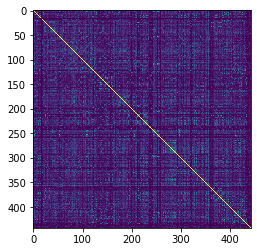

In [9]:
similarities = sentence_similarity(clean_sentences, stop_word_language='nl')
plt.imshow(similarities)

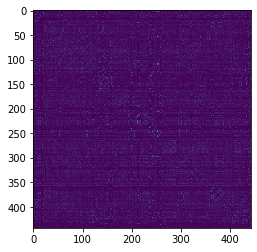

In [10]:
weights = edge_weights(similarities, d=0.85)
plt.imshow(weights)

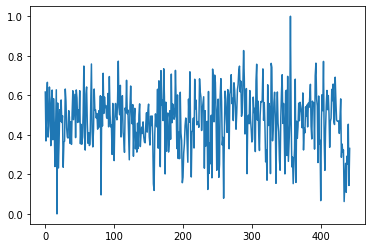

In [11]:
ranks = compute_rank_eigenvector(weights)
plt.plot(ranks)

In [12]:
print_summary(sentences, ranks, max_sentences=20)